# Project 3 -- predicting cloud cover 

In [60]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

from model_comparison import model_comparison
from resample import resample
import algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as n
from sklearn.linear_model import LinearRegression

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from utils import train_test_split
from utils import mean_squared_error, r2_score
#%matplotlib notebook

from sklearn.preprocessing import StandardScaler

In [3]:
def logit_inv(x): 
    return np.exp(x)/(1 + np.exp(x))

def logit(x):
    return np.log(x+1e-12) - np.log(1+1e-12-x)

# Reading in the data

In [4]:
# reading test
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

In [5]:
#print(cloud.variables)
tcc = cloud.variables["tcc"][:][:][:].data

# Retriving ground values, these are available at six different pressure levels. 
rel = relative.variables["r"][:][:][:][:].data
#level = relative.variables["level"][:][0].data
spe = specific.variables["q"][:][:][:][:].data

surf_pre = pressure.variables["sp"][:][:][:].data
temp = temperature.variables["t2m"][:][:][:].data

In [6]:
rel.shape

(32, 6, 61, 77)

In [7]:
temp.shape

(32, 61, 77)

In [8]:
# Choosing the number of days for training and testing.

In [9]:
# for one certain timestep 

n_days = 7

TCC = []
REL = []
SPE = []
PRE = []
TEMP = []


for t in range(n_days*4):
    TCC.append(tcc[t][:][:].flatten())
    #print(rel[t][0].flatten().shape)
    REL.append(rel[t][0][:][:].flatten())
    SPE.append(spe[t][0][:][:].flatten())
    PRE.append(surf_pre[t][:][:].flatten())
    TEMP.append(temp[t][:][:].flatten())


In [10]:
y =(np.array(TCC).flatten())
temp = y[y<1]
#y[y>1] = temp.max()
#X = np.array([np.array(REL).flatten(), np.array(SPE).flatten(), np.array(PRE).flatten(), np.array(TEMP).flatten()])
#y = logit(np.array(TCC).flatten())

In [11]:
# Need to determine the largest number smaller than zero to swap all elements larger than one with this...
temp.max()

0.9999694810258271

In [12]:
y[y>1] = temp.max()

In [13]:
X = np.array([np.array(REL).flatten(), np.array(SPE).flatten(), np.array(PRE).flatten(), np.array(TEMP).flatten()])
y = logit(np.array(TCC).flatten())

In [14]:
y.shape

(131516,)

In [15]:
X[0].shape, X[1].shape ,X[2].shape, X[3].shape

((131516,), (131516,), (131516,), (131516,))

In [16]:
X = X.transpose()

In [17]:
X.shape

(131516, 4)

In [18]:
y.max(), y.min()

(36.04365338911915, -26.93794050959591)


# Regression analysis -- with logit

In [24]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    #"ols": LinearRegression,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}
param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5]
}

# Choosing the same splitsize as the notebook in order to compare. 
results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X, y, split_size=0.2
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
0


In [25]:
results.keys()

dict_keys(['mse_test', 'mse_train', 'r2_test', 'r2_train'])

In [26]:
results["r2_test"]["ridge"]

[[0.18942827768851322,
  0.18943285090842954,
  0.1894708107261588,
  0.18939450769552402,
  0.18673880201555493,
  0.18481474353616545,
  0.18453029471642823,
  0.1845007420608199,
  0.18449962531266273,
  0.1845149133827022]]

In [27]:
results["r2_test"]["ols"]

[[0.19172666556080775]]

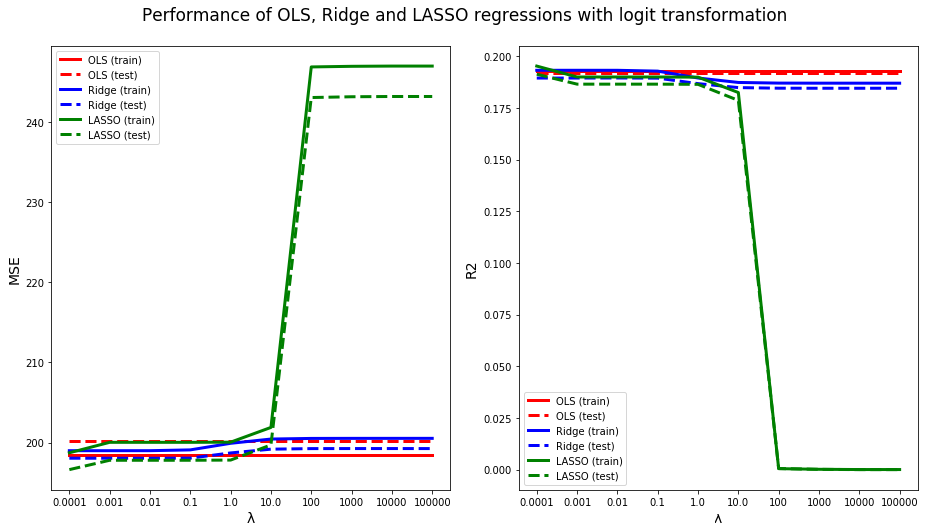

In [28]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions with logit transformation", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData_with_Logit.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()

# Regression analysis without logit

In [29]:
y = logit_inv(y) #transforming the data back. 

results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X, y, split_size=0.2
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
2


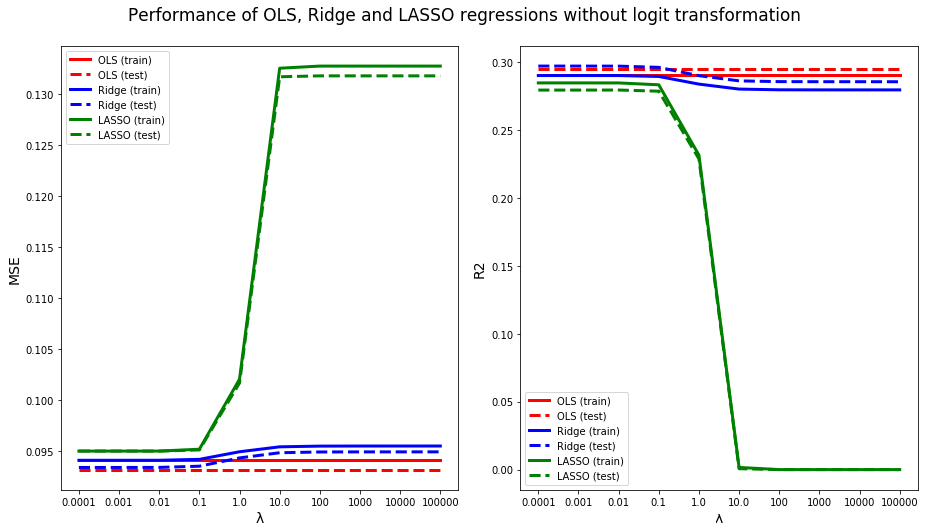

In [30]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions without logit transformation", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData_withoutLogit.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()

# Can we based on these pictures conclude that penalties doesn't hava an effect???

# Determining which feature is most important

## Results:

# Bias and variance discussion 

In [31]:
# Experimental setup
models = {
    "ols": algorithms.OLS, 
    "ridge": algorithms.Ridge, 
    "lasso": algorithms.Lasso, 
}

lmd = {
    'ols': [0],
    'lasso': [0.001],
    'ridge':[0.001]
    
}
nboots = 100

z_test, z_pred_test, bias, var, beta, mse_test, mse_train, ci_beta = resample(models, lmd, X, y, nboots, split_size = 0.2)

ci_beta.shape

(2, 4)

In [32]:
ci_beta.shape # Muligens ikke så mys vits med konfidenseintervall av disse dimensjoner. 

(2, 4)

In [33]:
bias

{'ridge': 0.09348112225774756,
 'lasso': 0.09455092817801955,
 'ols': 0.093481922909198}

In [34]:
var # variance dominates because we don't have so mush data???

{'ridge': 3.726823662163387e-06,
 'lasso': 3.6576771037659196e-06,
 'ols': 4.045297388592473e-06}

In [35]:
mse_test

{'ridge': 0.09348484908140971,
 'lasso': 0.09455458585512332,
 'ols': 0.0934859682065866}

In [36]:
bias["ols"] + var["ols"] 

0.0934859682065866

In [37]:
bias["ridge"] + var["ridge"] 

0.09348484908140972

In [38]:
bias["lasso"] + var["lasso"] 

0.09455458585512332

The bias and variance summes to the mse of the ols model.

In [39]:
#logit_inv(z_pred_best["lasso"])

# Compare with scikit learn without logit

In [51]:
y = logit_inv(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size = 0.5)

In [52]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
p = model.predict(X_test)
model.score(X_test, y_test) #returns the r2 score

0.3064337511939934

In [53]:
model.coef_

array([ 1.54452750e-02, -7.34769045e+01,  5.93201489e-06,  1.29781487e-02])

In [ ]:
# relative humidity, specific humidity, pressure, temprature

# With logit transformation

In [43]:
y

array([0.99996948, 0.99996948, 1.        , ..., 0.07617536, 0.20113531,
       0.49411747])

In [54]:
y = logit(y)

In [55]:
y.min(), y.max()

(-26.244760041368796, 26.937674032465715)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size = 0.5)

model = LinearRegression()
model.fit(X_train, y_train)
p = model.predict(X_test)
model.score(X_test, y_test) #returns the r2 score

0.21345685024686842

In [57]:
X_b = logit_inv(p)
y_b = logit_inv(y_test)

r2_score( X_b, y_b  )

-0.13802646024666032

In [58]:
model.coef_

array([ 4.24562969e-01, -1.43592425e+03,  5.58367368e-05,  2.02207520e-01])

In [ ]:
# relative humidity, specific humidity, pressure, temprature

# Linear regression using standard scaler

In [62]:
scaler = StandardScaler()
fit = scaler.fit(X)
p = scaler.transform(X)

In [74]:
#y = logit_inv(y)

#scaler = StandardScaler()
#fit = scaler.fit(y)
#yy = scaler.transform(y)

In [66]:
p

array([[ 1.26733946, -1.72037237,  0.53591332, -3.05580049],
       [ 1.20928871, -1.71051398,  0.53484103, -2.98743943],
       [ 1.19800871, -1.69197592,  0.52679884, -2.82467501],
       ...,
       [-2.15971843,  0.56205941, -1.33234106,  1.48194626],
       [-2.28641213,  0.43615061, -1.06512589,  1.50448288],
       [-2.40388925,  0.36735619, -0.75684194,  1.54354634]])

In [72]:
y

array([0.99996948, 0.99996948, 1.        , ..., 0.07617536, 0.20113531,
       0.49411747])

In [68]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    #"ols": LinearRegression,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}
param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5]
}

# Choosing the same splitsize as the notebook in order to compare. 
results, z_pred_best, coeffs = model_comparison(
    models, param_grid, p, y, split_size=0.2
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
0


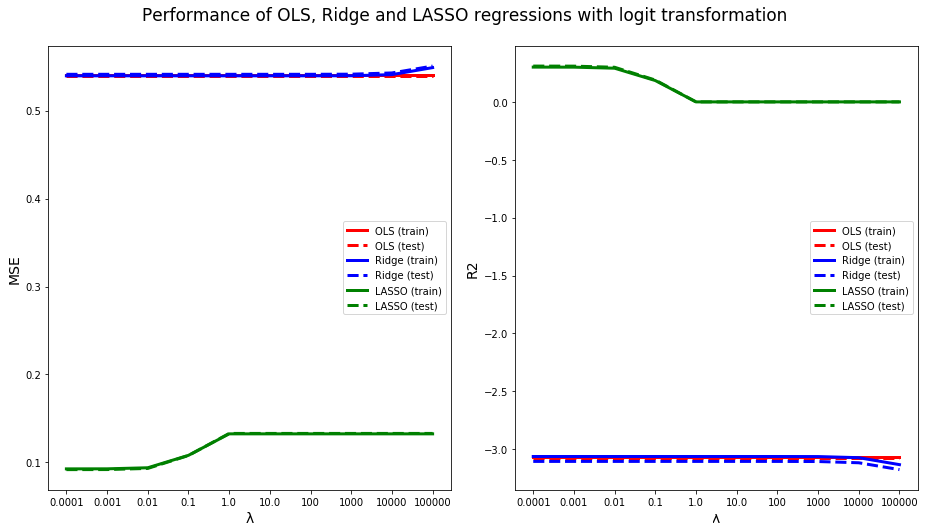

In [71]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions with logit transformation", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData_with_Logit.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()